In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import keras.backend as K #to define custom loss function

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from collections import defaultdict
import openslide
from openslide import OpenSlide

from glob import glob

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D

In [2]:
train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_df  = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


## Data viusalization

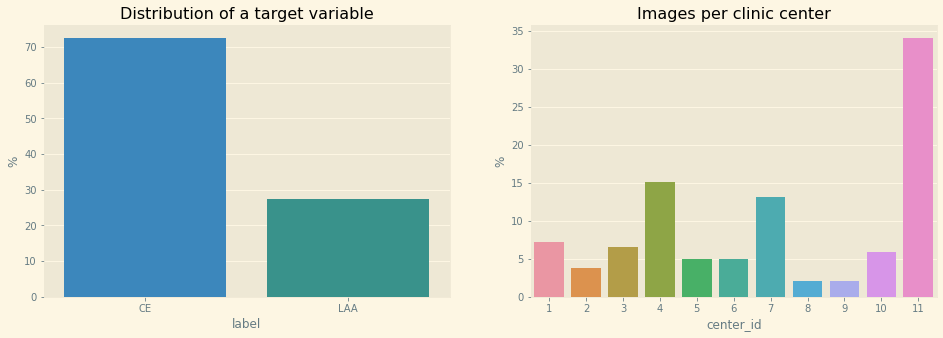

Train Size = 754
Test Size = 4


In [3]:
##### CLASS DISTRIBUTION

plt.style.use('Solarize_Light2')
labels = train_df.groupby('label')['label'].count().div(len(train_df)).mul(100)
centers = train_df.groupby("center_id")['center_id'].count().div(len(train_df)).mul(100)

fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.barplot(x=labels.index, y=labels.values, ax=ax[0])
ax[0].set_title("Distribution of a target variable"), ax[0].set_ylabel("%")
sns.barplot(x=centers.index, y=centers.values, ax=ax[1])
ax[1].set_title("Images per clinic center"), ax[1].set_ylabel("%")
plt.show()

print('Train Size = {}'.format(len(train_df)))
print('Test Size = {}'.format(len(test_df)))



## From this plot we notice that there is a class imbalance which we will deal with later in this notebook

In [4]:
train_images = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")
test_images = glob("/kaggle/input/mayo-clinic-strip-ai/test/*")
other_images = glob("/kaggle/input/mayo-clinic-strip-ai/other/*")
print(f"Number of images in a training set: {len(train_images)}")
print(f"Number of images in a training set: {len(test_images)}")
print(f"Number of other: {len(other_images)}")

Number of images in a training set: 754
Number of images in a training set: 4
Number of other: 396


In [5]:
img_prop = defaultdict(list)

for i, path in enumerate(train_images):
    img_path = train_images[i]
    slide = OpenSlide(img_path)    
    img_prop['image_id'].append(img_path[-12:-4])
    img_prop['width'].append(slide.dimensions[0])
    img_prop['height'].append(slide.dimensions[1])
    img_prop['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    img_prop['path'].append(img_path)

image_data = pd.DataFrame(img_prop)
image_data['img_aspect_ratio'] = image_data['width']/image_data['height']
image_data.sort_values(by='image_id', inplace=True)
image_data.reset_index(inplace=True, drop=True)

image_data = image_data.merge(train_df, on='image_id')
image_data.head()

,image_id,width,height,size,path,img_aspect_ratio,center_id,patient_id,image_num,label
0,006388_0,34007,60797,1312.94,/kaggle/input/mayo-clinic-strip-ai/train/00638...,0.559353,11,006388,0,CE
1,008e5c_0,5946,29694,109.57,/kaggle/input/mayo-clinic-strip-ai/train/008e5...,0.200242,11,008e5c,0,CE
2,00c058_0,15255,61801,351.76,/kaggle/input/mayo-clinic-strip-ai/train/00c05...,0.246841,11,00c058,0,LAA
3,01adc5_0,55831,26553,679.17,/kaggle/input/mayo-clinic-strip-ai/train/01adc...,2.102625,11,01adc5,0,LAA
4,026c97_0,10533,8267,61.21,/kaggle/input/mayo-clinic-strip-ai/train/026c9...,1.274102,4,026c97,0,CE


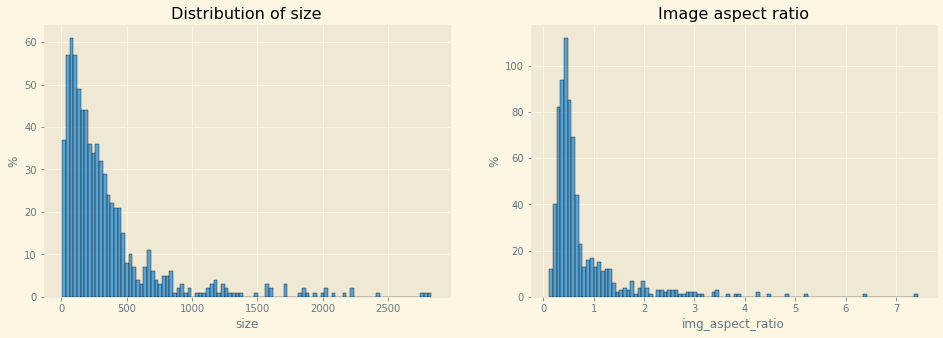

In [6]:
plt.style.use('Solarize_Light2')

fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.histplot(x='size', data = image_data, bins=100, ax=ax[0])
ax[0].set_title("Distribution of size"), ax[0].set_ylabel("%")
sns.histplot(x='img_aspect_ratio', data = image_data, bins=100, ax=ax[1])
ax[1].set_title("Image aspect ratio"), ax[1].set_ylabel("%")
plt.show()

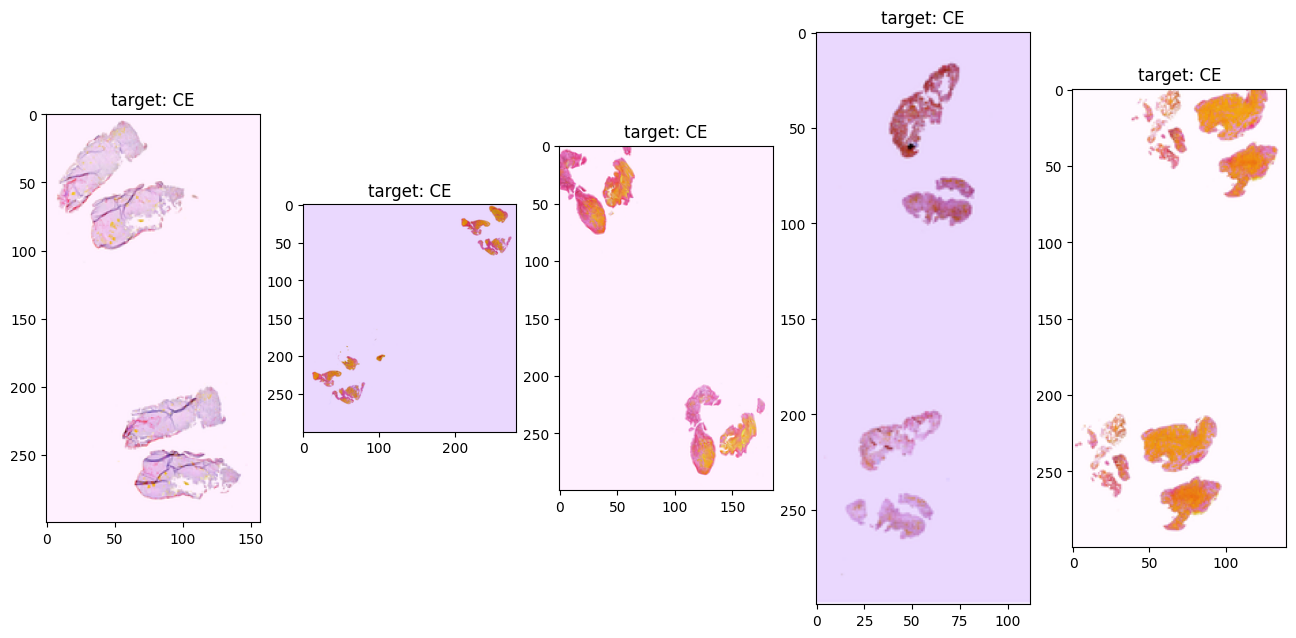

In [7]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None 

CE_imgs = image_data.loc[image_data['label']=='CE','path']
LAA_imgs = image_data.loc[image_data['label']=='LAA','path']


plt.style.use('default')
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(CE_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: CE")
plt.show()

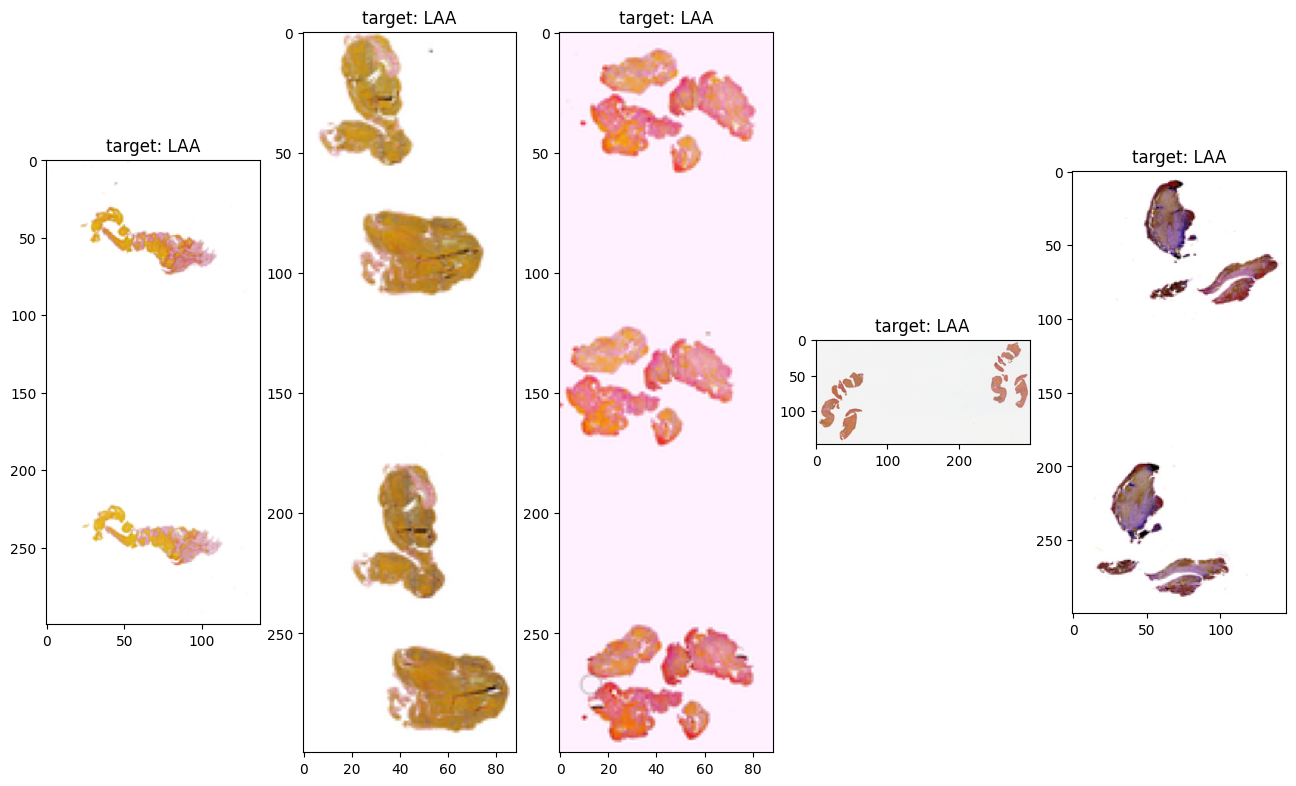

In [8]:
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(LAA_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: LAA")
plt.show()

## First impressions:

- Images sizes are from small ones to a high-resolution ones
- Images have different aspect ratios
- Backgrounds have different colours
- Clots are usually in the form of multiple small pieces
- Blood clots have different colours

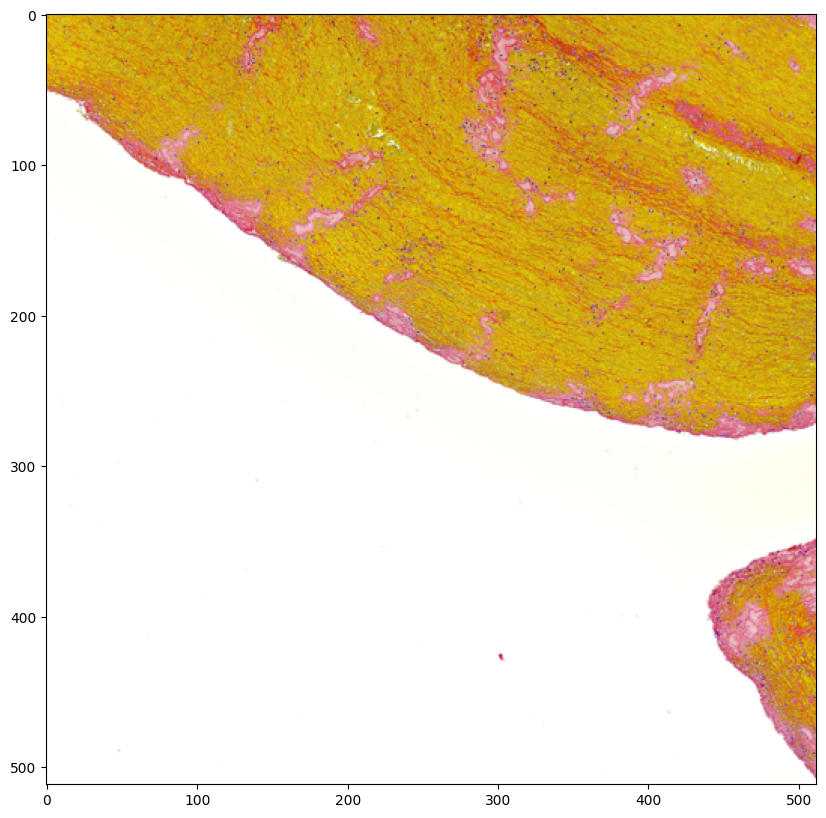

In [9]:
slide = OpenSlide('/kaggle/input/mayo-clinic-strip-ai/train/026c97_0.tif') # opening a full slide

region = (2500, 2000) # location of the top left pixel
level = 0 # level of the picture (we have only 0)
size = (3500, 3500) # region size in pixels

region = slide.read_region(region, level, size)
image = region.resize((512, 512))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()


![image](https://upload.wikimedia.org/wikipedia/commons/0/06/Composition_of_a_fresh_thrombus.jpg)

## Approach 1

## Loading Data

In [10]:
train_df["file_path"] = train_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")

In [11]:
# labelling CE class as 1 and LAA as 0
train_df["target"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0)
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif,1
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,1
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif,0
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,0
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif,1


## Preprocessing

In [12]:
%%time
def preprocess(image_path):
    slide=OpenSlide(image_path)
    region= (2500,2500)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size)
    image = image.resize((128, 128))
    image = np.array(image)    
    return image

X_train=[]
for i in tqdm(train_df['file_path']):
    x1=preprocess(i)
    X_train.append(x1)

Y_train=[]    
Y_train=train_df['target'] 

100%|██████████| 754/754 [45:50<00:00,  3.65s/it]

CPU times: user 15min 40s, sys: 3min 19s, total: 18min 59s
Wall time: 45min 50s


In [13]:
X_train=np.array(X_train)
Y_train = np.array(Y_train)

In [14]:
## Splitting data
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train,stratify=Y_train, test_size=0.2, random_state=42)

In [15]:
print(x_train.shape)

(603, 128, 128, 4)


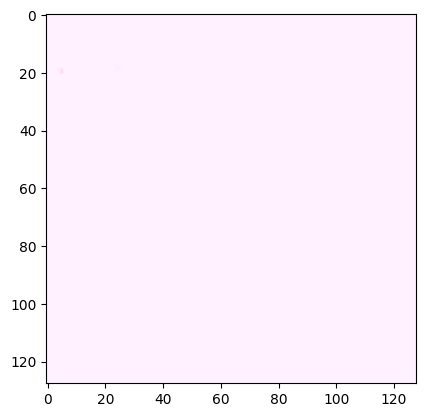

In [16]:
plt.imshow(x_train[1])

## Our CNN approach

In [17]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [18]:
from keras import metrics

model = Sequential()
input_shape = (128, 128, 4)

model.add(Conv2D(filters=64, kernel_size = (3,3), padding = 'valid', activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=128, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(Conv2D(filters=128, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))

model.add(Dropout(0.13))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.13))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1 , activation="sigmoid"))

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics.binary_accuracy,f1_score],
    optimizer = tf.keras.optimizers.Adam(1e-3))

2023-01-03 21:49:08.285634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 21:49:08.461092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 21:49:08.461898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 21:49:08.464385: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

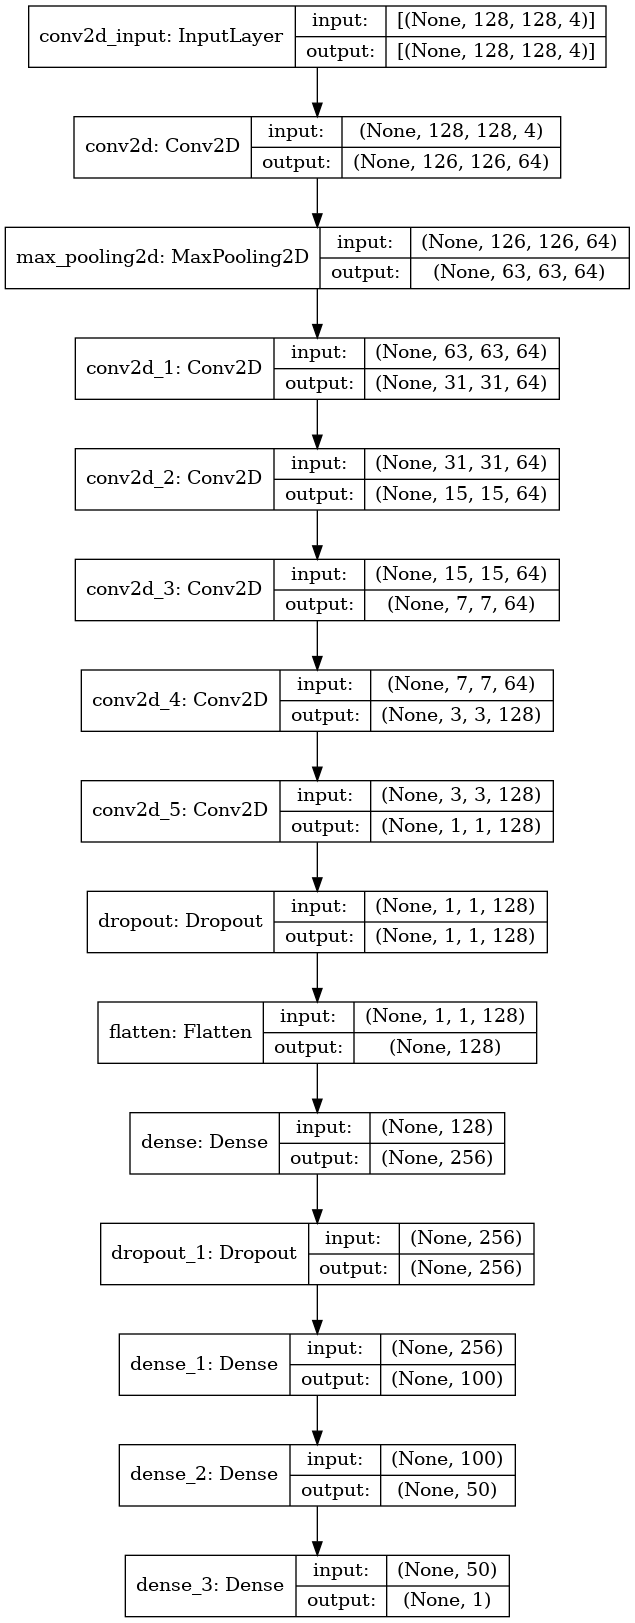

In [19]:
dot_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## This is where we balance class weights

In [20]:
from sklearn.utils import compute_class_weight
train_classes = Y_train
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 1.821256038647343, 1: 0.6892138939670932}

## Training the model

In [21]:
model.fit(
    x_train,
    y_train,
    epochs = 10,
    batch_size=20,
    validation_data = (x_test,y_test),
    class_weight= class_weights
)

2023-01-03 21:49:12.831714: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 39518208 exceeds 10% of free system memory.
2023-01-03 21:49:12.958999: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 39518208 exceeds 10% of free system memory.
2023-01-03 21:49:13.021598: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-03 21:49:15.045805: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


31/31 [==============================] - 8s 23ms/step - loss: 1.0086 - binary_accuracy: 0.5390 - f1_score: 0.5971 - val_loss: 0.6243 - val_binary_accuracy: 0.7219 - val_f1_score: 0.8314
Epoch 2/10
31/31 [==============================] - 0s 12ms/step - loss: 0.7088 - binary_accuracy: 0.5041 - f1_score: 0.5306 - val_loss: 0.7489 - val_binary_accuracy: 0.2715 - val_f1_score: 0.0000e+00
Epoch 3/10
31/31 [==============================] - 0s 12ms/step - loss: 0.7032 - binary_accuracy: 0.4411 - f1_score: 0.4332 - val_loss: 0.6918 - val_binary_accuracy: 0.6490 - val_f1_score: 0.7769
Epoch 4/10
31/31 [==============================] - 0s 12ms/step - loss: 0.6971 - binary_accuracy: 0.5124 - f1_score: 0.5494 - val_loss: 0.7193 - val_binary_accuracy: 0.2781 - val_f1_score: 0.0125
Epoch 5/10
31/31 [==============================] - 0s 12ms/step - loss: 0.6965 - binary_accuracy: 0.4660 - f1_score: 0.4397 - val_loss: 0.6964 - val_binary_accuracy: 0.3046 - val_f1_score: 0.0897
Epoch 6/10
31/31 [====

In [22]:
model.evaluate(x_test,y_test)

5/5 [==============================] - 0s 16ms/step - loss: 0.7042 - binary_accuracy: 0.6159 - f1_score: 0.7158


[0.7041864395141602, 0.6158940196037292, 0.7157888412475586]

Text(0.5, 25.722222222222214, 'Actual')

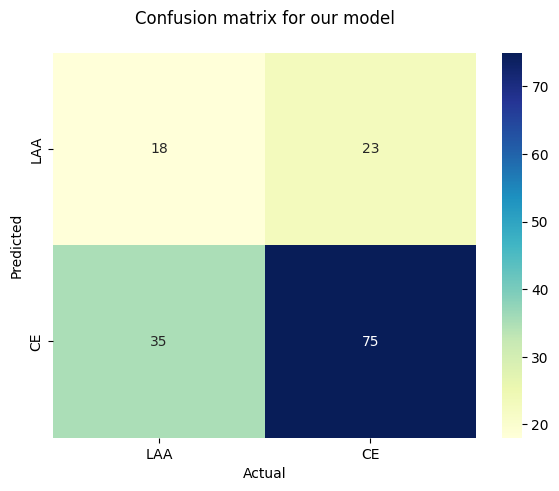

In [23]:
# Plot confusion matrices for benchmark and transfer learning models
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = model.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)

cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for our model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

## Submission for kaggle competition

In [24]:
test1=[]
for i in test_df['file_path']:
    x1=preprocess(i)
    test1.append(x1)
    print(i)
    
test1=np.array(test1)


../input/mayo-clinic-strip-ai/test/006388_0.tif
../input/mayo-clinic-strip-ai/test/008e5c_0.tif
../input/mayo-clinic-strip-ai/test/00c058_0.tif
../input/mayo-clinic-strip-ai/test/01adc5_0.tif


In [25]:
cnn_pred=model.predict(test1)
cnn_pred

array([[0.4925961 ],
       [0.4695087 ],
       [0.4990796 ],
       [0.49867293]], dtype=float32)

In [26]:
sub = pd.DataFrame(test_df["patient_id"].copy())
sub["CE"] = cnn_pred
sub["LAA"] = 1- sub["CE"]

sub = sub.groupby("patient_id").mean()
sub = sub[["CE", "LAA"]].round(6).reset_index()
sub

,patient_id,CE,LAA
0,006388,0.492596,0.507404
1,008e5c,0.469509,0.530491
2,00c058,0.499080,0.500920
3,01adc5,0.498673,0.501327


In [27]:
sub.to_csv("submission.csv", index = False)
!head submission.csv

patient_id,CE,LAA
006388,0.492596,0.507404
008e5c,0.469509,0.530491
00c058,0.49908,0.50092
01adc5,0.498673,0.501327


# Approach 2

## DenseNET

In [28]:
# del X_train
# del Y_train

In [29]:
# train_df.head()

In [30]:
# %%time
# def preprocess_RGB(image_path):
#     slide=OpenSlide(image_path)
#     region= (2500,2500)    
#     size  = (5000, 5000)
#     image = slide.read_region(region, 0, size).convert('RGB')
#     image = image.resize((128, 128))
#     image = np.array(image)    
#     return image

# X_train=[]
# for i in tqdm(train_df['file_path']):
#     #print(i)
#     x1=preprocess_RGB(i)
#     X_train.append(x1)
    
# Y_train=train_df['target']

In [31]:
# X_train=np.array(X_train)
# Y_train = np.array(Y_train)

# ## Splitting data
# x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train,stratify=Y_train, test_size=0.2, random_state=42)

In [32]:
# x_train.shape

In [33]:
# plt.imshow(x_train[1])

In [34]:
# def f1_score(y_true, y_pred): 
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val

In [35]:
# from sklearn.utils import compute_class_weight
# train_classes = Y_train
# class_weights = compute_class_weight(
#                                         class_weight = "balanced",
#                                         classes = np.unique(train_classes),
#                                         y = train_classes                                                    
#                                     )
# class_weights = dict(zip(np.unique(train_classes), class_weights))
# class_weights

In [36]:
# from tensorflow.keras.optimizers import Adam
# from keras.models import Sequential
# from tensorflow.keras.applications import DenseNet121
# from keras import layers
# from keras import metrics

# effnet = DenseNet121(
#         weights='imagenet',
#         include_top=False,
#         input_shape=(128,128,3)
# )

# for layer in effnet.layers[:-8]:
#     layer.trainable = False
# for layer in effnet.layers[-8:]:
#     layer.trainable = True

# Dense_model = Sequential()
# Dense_model.add(effnet)
# Dense_model.add(layers.GlobalAveragePooling2D())
# Dense_model.add(layers.Dropout(0.5))
# Dense_model.add(layers.Dense(512,activation='relu'))
# Dense_model.add(layers.Dense(64,activation='relu'))
# Dense_model.add(layers.Dense(1, activation='sigmoid'))

# Dense_model.compile(
#     loss = tf.keras.losses.BinaryCrossentropy(),
#     metrics=[metrics.binary_accuracy,f1_score],
#     optimizer = tf.keras.optimizers.Adam(1e-3))

# Dense_model.summary()

In [37]:
# dot_img_file = 'model.png'
# tf.keras.utils.plot_model(Dense_model, to_file=dot_img_file, show_shapes=True)

In [38]:
# Dense_model.fit(
#     x_train,
#     y_train,
#     epochs = 10,
#     batch_size=20,
#     validation_data = (x_test,y_test),
#     class_weight= class_weights
# )

In [39]:
# Dense_model.evaluate(x_test,y_test)

In [40]:
# # Plot confusion matrices for benchmark and transfer learning models
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# plt.figure(figsize=(15, 5))

# preds = Dense_model.predict(x_test)
# preds = (preds >= 0.5).astype(np.int32)

# cm = confusion_matrix(y_test, preds)
# df_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
# plt.subplot(121)
# plt.title("Confusion matrix for our model\n")
# sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
# plt.ylabel("Predicted")
# plt.xlabel("Actual")